In [1]:
%cd "D:\大数据管理\数据挖掘实战\用户数据分析"

D:\大数据管理\数据挖掘实战\用户数据分析


In [2]:
%pwd

'D:\\大数据管理\\数据挖掘实战\\用户数据分析'

In [3]:
%matplotlib inline  # 允许在Jupyter Notebook中直接显示Matplotlib图形

UsageError: unrecognized arguments: # 允许在Jupyter Notebook中直接显示Matplotlib图形


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
plt.style.use('ggplot')  # R语言绘图库风格

# 1. 数据导入

csv.reader 允许逐行读取文件，这样可以方便地获取第一行数据，也就是列名。在读取大型文件时，这种方法可以避免一次性加载整个文件到内存中。
pd.read_csv 会一次性加载整个文件到内存中，如果文件非常大，可能会导致内存问题,同时它的参数delimiter=' ' 仅能处理单个空格作为分隔符，若文件中存在多个连续空格，就会把它们当作数据内容。
pd.read_table ： sep='\s+' 更灵活，能处理包含多个连续空格、制表符等多种空白字符作为分隔符的情况。

In [13]:
# 先采用下面的方法是因为在读取大型文件时，使用csv.read可以避免一次性加载整个文件到内存中。
import csv
with open('CDNOW_master.txt', 'r') as file:
    reader = csv.reader(file, delimiter=' ')
    # 读取第一行
    columns = next(reader)
    # 去除空字符串
    columns = [col for col in columns if col]
    print('数据集的列名：', columns)

df = pd.read_table('CDNOW_master.txt',sep=r'\s+') # sep='\s+' 匹配任意个空格

数据集的列名： ['customer_id', 'date', 'number_of_cds', 'dollar_value']


In [7]:
plt.rcParams['font.sans-serif']= 'SimHei'

In [8]:
df.head()

,customer_id,date,number_of_cds,dollar_value
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


# 2. 数据清洗

## 2.1 数据的处理（缺失值、重复值、异常值和日期列格式的转化）

In [14]:
# 缺失值处理
df = df.dropna()
# 重复值处理
df = df.drop_duplicates()
# 异常值处理（这里简单假设数值列的异常值为超出均值3倍标准差的值）
for col in ['dollar_value', 'number_of_cds']:
    mean = df[col].mean()
    std = df[col].std()
    df = df[(df[col] <= mean + 3 * std) & (df[col] >= mean - 3 * std)]

In [10]:
# 实际的数据文件可能会因为各种原因（例如数据收集变更、数据预处理差异等）缺失某些列。
# 添加 if 语句可以让代码在不同的数据格式下都能正常运行，增强了代码的灵活性与健壮性。
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])# 如果在将date列转换为日期格式时出现问题，可能会导致所有日期被解析为相同的值。

In [15]:
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')

In [16]:
df['date'].head()

0   1997-01-01
1   1997-01-12
2   1997-01-12
3   1997-01-02
4   1997-03-30
Name: date, dtype: datetime64[ns]

## 2.2 数据的探索性分析

In [17]:
# 统计不同列的唯一值数量
unique_counts = df.nunique()
print('不同列的唯一值数量：')
print(unique_counts)

不同列的唯一值数量：
customer_id      23303
date               546
number_of_cds        7
dollar_value      6375
dtype: int64


# 3 用户购买行为分析

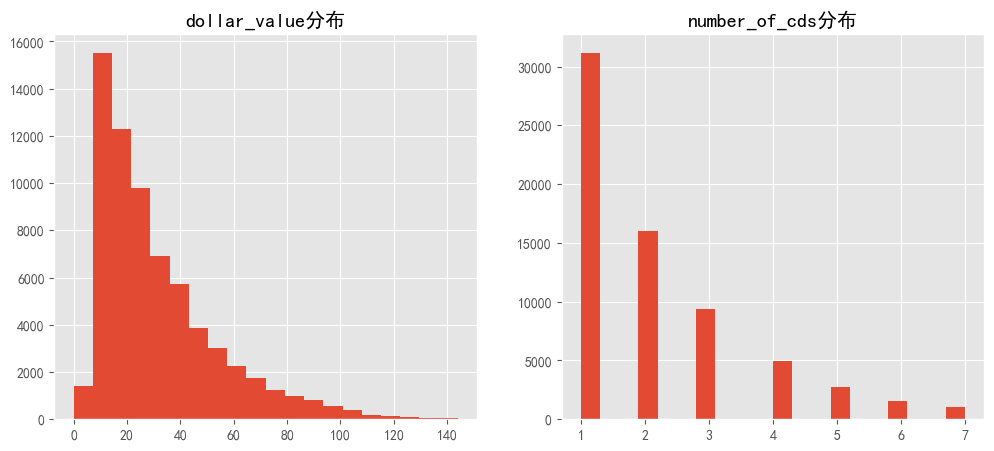

In [18]:
# 分析amount_product和num_product的分布情况
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 建立一个1行2列的子图布局
axes[0].hist(df['dollar_value'], bins=20)  # 将数据分为20个区间
axes[0].set_title('dollar_value分布')
axes[1].hist(df['number_of_cds'], bins=20)
axes[1].set_title('number_of_cds分布')
plt.show()


In [19]:
#  计算不同时间段（按天）的购买次数和购买金额总和
if 'date' in df.columns:
    daily_purchase = df.groupby(df['date'].dt.date).agg({
        'customer_id': 'count',
        'dollar_value': 'sum'
    })
    daily_purchase.columns = ['购买次数', '购买金额总和']
    print('按天统计的购买次数和购买金额总和：')
    print(daily_purchase)

按天统计的购买次数和购买金额总和：
            购买次数   购买金额总和
date                     
1997-01-01   205  6133.80
1997-01-02   243  7393.05
1997-01-03   230  6826.77
1997-01-04   171  5644.63
1997-01-05   245  7641.90
...          ...      ...
1998-06-26    46  1632.14
1998-06-27    68  2354.84
1998-06-28    49  1223.97
1998-06-29    61  1989.37
1998-06-30    55  1881.18

[546 rows x 2 columns]


In [20]:
# 计算每个用户的总消费金额和总购买数量
user_value = df.groupby('customer_id').agg({
    'dollar_value': 'sum',
    'number_of_cds': 'sum'
})
user_value.columns = ['总消费金额', '总购买数量']

In [21]:
# 对用户进行分层
# 假设按照总消费金额的高低分为高、中、低价值用户
quantiles = user_value['总消费金额'].quantile([0.25, 0.75]) # 计算分位数
low_value = user_value[user_value['总消费金额'] <= quantiles.loc[0.25]]
medium_value = user_value[(user_value['总消费金额'] > quantiles.loc[0.25]) & (user_value['总消费金额'] <= quantiles.loc[0.75])]
high_value = user_value[user_value['总消费金额'] > quantiles.loc[0.75]]

print('低价值用户数量：', len(low_value))
print('中价值用户数量：', len(medium_value))
print('高价值用户数量：', len(high_value))

低价值用户数量： 5826
中价值用户数量： 11651
高价值用户数量： 5826


# 4 客单价现状分析

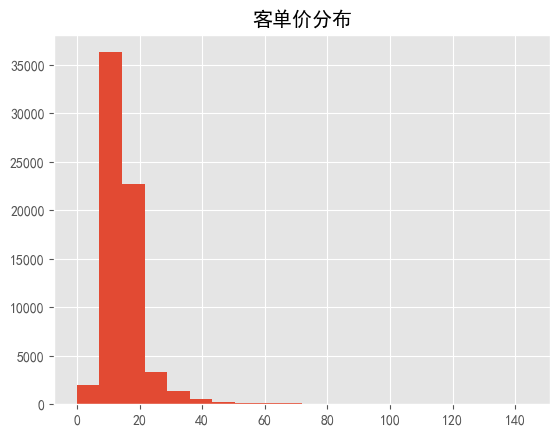

平均客单价： 15.327561809078805
客单价中位数： 13.99
客单价标准差： 7.473702225093378


In [22]:
# 客单价总体分布
# 计算客单价
if 'dollar_value' in df.columns and 'number_of_cds' in df.columns:
    df['客单价'] = df['dollar_value'] / df['number_of_cds']
    plt.hist(df['客单价'], bins=20)
    plt.title('客单价分布')
    plt.show()

    # 计算平均客单价、中位数、标准差等统计量
    average_price = df['客单价'].mean()
    median_price = df['客单价'].median()
    std_price = df['客单价'].std()
    print('平均客单价：', average_price)
    print('客单价中位数：', median_price)
    print('客单价标准差：', std_price)

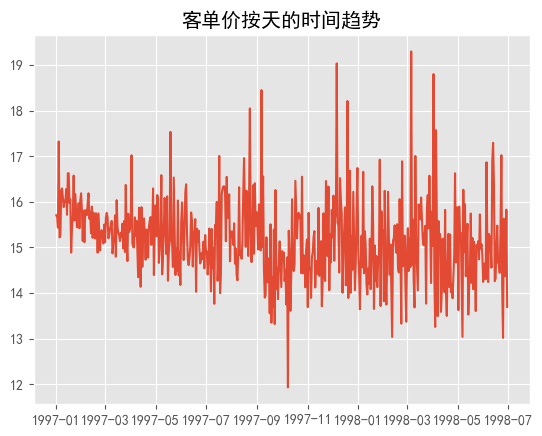

In [23]:
# 客单价的时间趋势
if 'date' in df.columns and '客单价' in df.columns:
    daily_avg_price = df.groupby(df['date'].dt.date)['客单价'].mean()
    plt.plot(daily_avg_price)
    plt.title('客单价按天的时间趋势')
    plt.show()

In [24]:
# 不同用户群体的客单价差异
# 这里简单按照购买频率和总消费金额进行分组
if 'customer_id' in df.columns and 'dollar_value' in df.columns:
    purchase_frequency = df.groupby('customer_id').size()  # 是在分组操作后使用的方法，它会返回每个分组中的元素数量。
    total_consumption = df.groupby('customer_id')['dollar_value'].sum()
    frequency_quantiles = purchase_frequency.quantile(0.5)
    consumption_quantiles = total_consumption.quantile(0.5)
    df = df.merge(purchase_frequency.rename('购买频率'), on='customer_id')
    df = df.merge(total_consumption.rename('总消费金额'), on='customer_id')
    df['购买频率等级'] = np.where(df['购买频率'] > frequency_quantiles, '高频', '低频')
    df['总消费等级'] = np.where(df['总消费金额'] > consumption_quantiles, '高消费', '低消费')
    df['用户群体'] = df['购买频率等级'] + df['总消费等级']
    group_price = df.groupby('用户群体')['客单价'].mean()
    print('不同用户群体的客单价：')
    print(group_price)

不同用户群体的客单价：
用户群体
低频低消费    14.698044
低频高消费    20.225615
高频低消费    13.132288
高频高消费    15.412415
Name: 客单价, dtype: float64


In [25]:
# 时间因素与客单价的关系
# 假设按照工作日和周末进行分析
if 'date' in df.columns and '客单价' in df.columns:
    df['是否周末'] = df['date'].dt.weekday >= 5
    weekend_price = df.groupby('是否周末')['客单价'].mean()
    print('工作日和周末的客单价：')
    print(weekend_price)

工作日和周末的客单价：
是否周末
False    15.315945
True     15.357193
Name: 客单价, dtype: float64


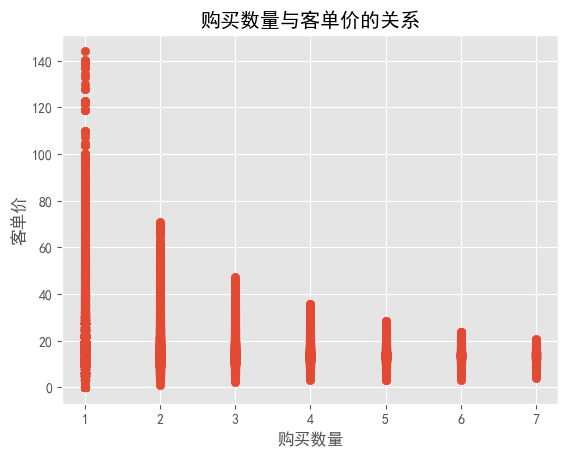

In [26]:
# 购买数量与客单价的关系
if 'number_of_cds' in df.columns and '客单价' in df.columns:
    plt.scatter(df['number_of_cds'], df['客单价'])
    plt.xlabel('购买数量')
    plt.ylabel('客单价')
    plt.title('购买数量与客单价的关系')
    plt.show()

In [39]:
# 模型所需要到的所有库
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [38]:
pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.9 MB/s eta 0:00:00


# 5 客户聚类分析

### 5.1 客户聚类分析模型构建（分析前的对分析目标的解构及安排）
### K-Means 聚类分析：
使用 总消费金额、总购买数量和购买时间跨度作为特征。
聚类结果通过散点图可视化，并输出每个群体的平均特征值。
### 逻辑回归模型预测：
构造模拟的营销策略响应数据。
使用逻辑回归模型预测客户对营销策略的响应概率。
输出模型评估结果和不同客户群体的预测响应率。

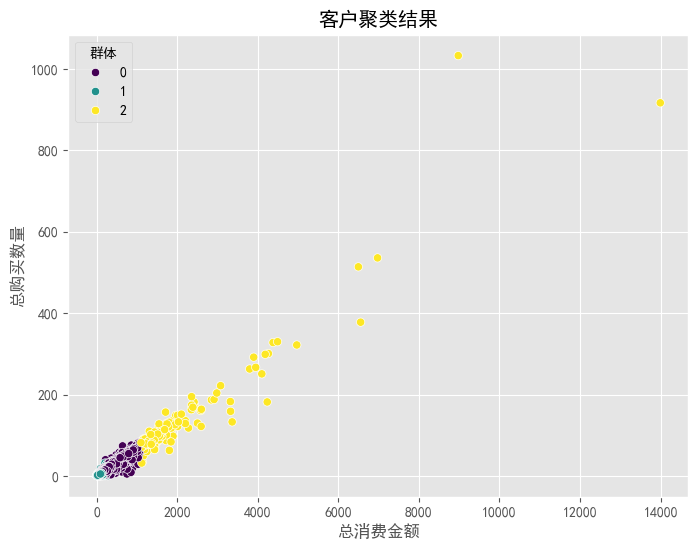

聚类结果：
     customer_id        总消费金额       总购买数量      购买时间跨度
群体                                                   
0   11578.544670   205.489544   13.885193  383.007932
1   11882.534998    42.755123    2.843663   21.652236
2   11275.195266  1954.990828  130.130178  447.017751


In [67]:
if 'customer_id' in df.columns and 'dollar_value' in df.columns and 'number_of_cds' in df.columns:
    clustering_data = df.groupby('customer_id').agg({
        'dollar_value': 'sum',
        'number_of_cds': 'sum',
        'date': lambda x: (x.max() - x.min()).days  # 计算购买时间跨度
    }).reset_index()
    clustering_data.columns = ['customer_id', '总消费金额', '总购买数量', '购买时间跨度']

    # K-Means 聚类
    kmeans = KMeans(n_clusters=3, random_state=42)
    clustering_data['群体'] = kmeans.fit_predict(clustering_data[['总消费金额', '总购买数量', '购买时间跨度']])

    #可视化聚类结果
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='总消费金额', y='总购买数量', hue='群体', data=clustering_data, palette='viridis'
    )
    plt.title('客户聚类结果')
    plt.show()

    print('聚类结果：')
    print(clustering_data.groupby('群体').mean())

## 5.2 营销策略响应预测

In [68]:
# 构造响应数据（假设已有营销策略响应数据）
# 在实际业务场景中，企业开展营销策略后，希望了解客户对这些策略的反应，例如客户是否会因为营销活动而增加购买行为、是否会注册会员等。
# 响应数据就是用来衡量客户对营销策略的反应情况的，它通常是一个二元变量（如 0 表示未响应，1 表示响应）。
# 在我的代码中，由于没有真实的营销策略响应数据，所以需要构造模拟的响应数据。
# 这是为了模拟真实的业务场景，让模型能够学习到客户特征与响应之间的关系，从而对未来的客户响应情况进行预测。
# 通过预测客户对营销策略的响应，企业可以有针对性地调整营销策略，提高营销效果和投资回报率。
if '群体' in clustering_data.columns:
    # 创建模拟响应数据
    np.random.seed(42)
    clustering_data['响应'] = np.random.choice([0, 1], size=len(clustering_data))  # 0: 未响应, 1: 响应

    # 数据划分
    X = clustering_data[['总消费金额', '总购买数量', '购买时间跨度', '群体']]
    y = clustering_data['响应']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 逻辑回归模型
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # 模型评估
    y_pred = model.predict(X_test)
    print('逻辑回归模型评估：')
    print(classification_report(y_test, y_pred))
    print('准确率：', accuracy_score(y_test, y_pred))

    # 业务应用建议
    clustering_data['预测响应'] = model.predict(X)
    print('不同客户群体的预测响应率：')
    print(clustering_data.groupby('群体')['预测响应'].mean())

逻辑回归模型评估：
              precision    recall  f1-score   support

           0       0.50      0.18      0.27      3546
           1       0.50      0.82      0.62      3525

    accuracy                           0.50      7071
   macro avg       0.50      0.50      0.44      7071
weighted avg       0.50      0.50      0.44      7071

准确率： 0.49964644321878093
不同客户群体的预测响应率：
群体
0    0.551350
1    0.939069
2    0.171598
Name: 预测响应, dtype: float64


模型输出结果解读如下：
1. 混淆矩阵相关指标
在机器学习分类问题中，对于二分类任务（这里是客户是否响应营销策略，即 0 代表未响应，1 代表响应），有以下关键指标：  
Precision（精确率）：精确率是指预测为正例的样本中，实际为正例的比例。公式为：Precision = \frac{TP}{TP + FP}，其中 TP 是真正例（预测为正例且实际为正例），FP 是假正例（预测为正例但实际为负例）。  
Recall（召回率）：召回率是指实际为正例的样本中，被预测为正例的比例。公式为：Recall = \frac{TP}{TP + FN}，其中 FN 是假负例（预测为负例但实际为正例）。  
F1 - score：F1 - score 是精确率和召回率的调和平均数，用于综合衡量模型的性能。公式为：F1 - score = 2\times\frac{Precision\times Recall}{Precision + Recall}。  
Support：支持度，表示该类别在测试集中的样本数量。  
3. 输出结果分析
类别 0（未响应）：  
精确率为 0.50，意味着在模型预测为未响应的样本中，有 50% 实际上是未响应的。  
召回率为 0.18，说明在实际未响应的样本中，只有 18% 被模型正确预测为未响应。  
F1 - score 为 0.27，是精确率和召回率的综合指标，数值较低表明该类别在精确率和召回率的平衡上表现不佳。  
支持度为 3546，即测试集中未响应的样本有 3546 个。  
类别 1（响应）：  
精确率为 0.50，即模型预测为响应的样本中，有 50% 实际上是响应的。  
召回率为 0.82，说明在实际响应的样本中，有 82% 被模型正确预测为响应。  
F1 - score 为 0.62，相对类别 0 较高，表明该类别在精确率和召回率的平衡上表现较好。  
支持度为 3525，即测试集中响应的样本有 3525 个。  
4. 整体评估指标分析
Accuracy（准确率）：准确率是指模型预测正确的样本占总样本的比例。这里准确率为 0.50，意味着模型在整个测试集上的预测正确率为 50%。总样本数为 7071（3546 + 3525）。  
Macro Avg（宏平均）：宏平均是对每个类别的指标（精确率、召回率、F1 - score）取平均值。这里宏平均精确率和召回率均为 0.50，F1 - score 为 0.44。  
Weighted Avg（加权平均）：加权平均是根据每个类别的支持度对指标进行加权平均。这里加权平均精确率和召回率均为 0.50，F1 - score 为 0.44。  
5. 不同客户群体的预测响应率
这部分结果展示了不同客户群体的预测响应率。根据前面的聚类分析，客户被分为了 3 个群体（群体 0、群体 1、群体 2）。预测响应率表示每个群体中被预测为响应营销策略的客户比例。  
群体 0 的预测响应率为 0.551350，即该群体中约有 55.14% 的客户被预测会响应营销策略。  
群体 1 的预测响应率为 0.939069，即该群体中约有 93.91% 的客户被预测会响应营销策略。  
群体 2 的预测响应率为 0.171598，即该群体中约有 17.16% 的客户被预测会响应营销策略。  
企业可以根据这些预测响应率，针对不同群体制定不同的营销策略，例如对预测响应率高的群体加大营销投入，对预测响应率低的群体调整营销策略或放弃营销。  

#### 为什么营销策略响应模型，会使用混淆矩阵相关指标（精确率、召回率、F1 - score等）作为模型输出结果？  
1. 单一指标的局限性  
准确率是最常用的模型评估指标之一，它表示模型预测正确的样本占总样本的比例。然而，在某些情况下，尤其是当数据类别不平衡时，准确率可能会给出误导性的结果。例如，在营销策略响应预测中，如果大部分客户都不响应营销策略（即类别0的样本数量远多于类别1），那么一个简单地将所有样本都预测为不响应的模型可能会获得较高的准确率，但这显然不是一个有用的模型。因此，需要使用其他指标来更全面地评估模型。
2. 混淆矩阵相关指标的作用  
精确率（Precision）  
精确率衡量的是模型预测为正例的样本中，实际为正例的比例。在营销策略响应预测中，精确率表示模型预测会响应营销策略的客户中，实际真正响应的客户比例。较高的精确率意味着模型在预测响应客户时的准确性较高，企业可以更有信心地针对这些预测为响应的客户制定营销策略，避免资源浪费在错误预测的客户上。  
召回率（Recall）  
召回率衡量的是实际为正例的样本中，被模型正确预测为正例的比例。在营销策略响应预测中，召回率表示实际会响应营销策略的客户中，被模型正确预测出来的比例。较高的召回率意味着模型能够尽可能多地识别出真正会响应的客户，帮助企业不遗漏潜在的响应客户，提高营销活动的覆盖范围。
F1 - score  
F1 - score是精确率和召回率的调和平均数，它综合考虑了精确率和召回率两个指标。在实际应用中，精确率和召回率往往是相互制约的，提高精确率可能会降低召回率，反之亦然。F1 - score可以帮助我们在精确率和召回率之间找到一个平衡，更全面地评估模型的性能。
3. 不同业务场景的需求
在营销策略响应预测中，不同的业务场景可能对精确率和召回率有不同的侧重。例如：  
如果企业的营销资源有限，更关注每一次营销活动的效果，那么可能更看重精确率，希望模型能够准确地预测出会响应的客户，避免资源浪费。  
如果企业希望尽可能地扩大营销活动的影响力，吸引更多的潜在客户，那么可能更看重召回率，希望模型能够识别出更多真正会响应的客户。  
通过同时输出精确率、召回率和F1 - score等指标，企业可以根据自身的业务需求和资源情况，综合评估模型的性能，并做出更合理的决策。
4. 全面评估模型  
除了精确率、召回率和F1 - score，混淆矩阵还可以提供其他有用的信息，如真正例（TP）、假正例（FP）、真负例（TN）和假负例（FN）的数量。这些信息可以帮助我们更深入地了解模型的预测情况，找出模型容易出错的地方，从而进行针对性的改进。  
综上所述，在营销策略响应预测中，使用混淆矩阵相关指标作为模型的输出结果，可以更全面、准确地评估模型的性能，为企业制定营销策略提供更有价值的参考。


## 5.3 模型优化

In [71]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [70]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [72]:
    # 模型优化
    # 特征工程：标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 数据平衡：使用 SMOTE 进行过采样,避免数据集中不同类别的样本数量差异很大。
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # 超参数调优：使用 GridSearchCV 优化逻辑回归模型
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],  # 正则化类型
        'solver': ['liblinear']  # 支持 l1 和 l2 的求解器
    }
    grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_resampled, y_resampled)

    # 输出最佳参数和模型性能
    best_model = grid_search.best_estimator_
    print('最佳参数：', grid_search.best_params_)
    print('最佳模型准确率：', grid_search.best_score_)

    # 使用优化后的模型进行预测
    y_pred_optimized = best_model.predict(X_test)
    print('优化后逻辑回归模型评估：')
    print(classification_report(y_test, y_pred_optimized))
    print('优化后准确率：', accuracy_score(y_test, y_pred_optimized))

最佳参数： {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
最佳模型准确率： 0.5
优化后逻辑回归模型评估：
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3546
           1       0.00      0.00      0.00      3525

    accuracy                           0.50      7071
   macro avg       0.25      0.50      0.33      7071
weighted avg       0.25      0.50      0.33      7071

优化后准确率： 0.5014849384811201


C:\Users\lei\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\lei\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lei\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lei\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_clas

# 6 流失预测模型的构建、训练及模型评估

## 6.1 流失预测模型构建

In [43]:
    # 构造流失标签（假设流失定义为最近购买时间超过一定天数）
#if 'customer_id' in df.columns and 'date' in df.columns:
    customer_last_purchase = df.groupby('customer_id')['date'].max().reset_index()
    customer_last_purchase['最近购买间隔天数'] = (df['date'].max() - customer_last_purchase['date']).dt.days
    threshold_days = 90  # 假设超过90天未购买定义为流失
    customer_last_purchase['是否流失'] = (customer_last_purchase['最近购买间隔天数'] > threshold_days).astype(int)

    # 构造特征
    customer_features = df.groupby('customer_id').agg({
        'dollar_value': 'sum',
        'number_of_cds': 'sum',
        'date': lambda x: (x.max() - x.min()).days,  # 购买时间跨度
    }).reset_index()
    customer_features.columns = ['customer_id', '总消费金额', '总购买数量', '购买时间跨度']
    customer_features['购买频率'] = df.groupby('customer_id').size().values  # 添加购买频率
    customer_data = customer_features.merge(customer_last_purchase[['customer_id','是否流失']], on='customer_id',how='left') 
    # 数据划分
    X = customer_data[['总消费金额', '总购买数量', '购买时间跨度', '购买频率']]
    y = customer_data['是否流失']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # 模型训练（使用 XGBoost 或 SVM）
    # 使用梯度提升树
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train, y_train)

    # 使用支持向量机
    svm_model = SVC(probability=True, random_state=42)
    svm_model.fit(X_train, y_train)
    # 模型训练（使用 LightGBM）
    # 创建 LightGBM 数据集
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
    
    # 设置 LightGBM 参数
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    params['early_stopping_round'] = 50  # Move early stopping to params
    # 训练 LightGBM 模型

    lgb_model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        num_boost_round=1000
    )

## 6.2 模型评估

In [44]:
    # 模型评估
    # 梯度提升树
    gb_pred = gb_model.predict(X_test)
    gb_auc = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])
    print('梯度提升树 AUC：', gb_auc)
    print('梯度提升树评估：')
    print(classification_report(y_test, gb_pred))
    # 支持向量机
    svm_pred = svm_model.predict(X_test)
    svm_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])
    print('支持向量机 AUC：', svm_auc)
    print('支持向量机评估：')
    print(classification_report(y_test, svm_pred))
    #  LightGBM 
    lgb_pred = (lgb_model.predict(X_test) > 0.5).astype(int)
    lgb_auc = roc_auc_score(y_test, lgb_model.predict(X_test))
    print('LightGBM AUC：', lgb_auc)
    print('LightGBM 评估：')
    print(classification_report(y_test, lgb_pred))

    # 业务应用建议
    customer_data['流失概率'] = lgb_model.predict(X)  # 使用 LightGBM 的预测概率
    #customer_data['流失概率'] = gb_model.predict_proba(X)[:, 1]  # 使用梯度提升树的预测概率
    high_risk_customers = customer_data[customer_data['流失概率'] > 0.7]  # 假设流失概率大于70%为高风险
    print('高流失风险客户：')
    print(high_risk_customers[['customer_id', '流失概率']])

    # 输出挽回策略建议
    print('挽回策略建议：')
    print('为高流失风险客户发送专属优惠券或个性化推荐，以提高客户活跃度。')

梯度提升树 AUC： 0.995172032120874
梯度提升树评估：
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       971
           1       0.98      0.99      0.98      6020

    accuracy                           0.97      6991
   macro avg       0.95      0.94      0.94      6991
weighted avg       0.97      0.97      0.97      6991

支持向量机 AUC： 0.9819720396481347
支持向量机评估：
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       971
           1       0.98      0.99      0.99      6020

    accuracy                           0.97      6991
   macro avg       0.95      0.94      0.95      6991
weighted avg       0.97      0.97      0.97      6991

LightGBM AUC： 0.9950890611795219
LightGBM 评估：
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       971
           1       0.98      0.99      0.98      6020

    accuracy                           0.97      6991
   ma